#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import sklearn 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.datetime import DatetimeFeatures
import joblib
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor


from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score

In [2]:
warnings.filterwarnings('ignore', category=UserWarning)


#### Display Settings

In [3]:
pd.set_option("display.max_columns", None) #display all columns

In [4]:
sklearn.set_config(transform_output = "default") 

#### Import Data

The following datasets are the cleaned versions of original datasets

In [5]:
train = pd.read_csv("https://raw.githubusercontent.com/MisbahullahSheriff/sagemaker-flight-prices-prediction/master/data/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/MisbahullahSheriff/sagemaker-flight-prices-prediction/master/data/test.csv")
val = pd.read_csv("https://raw.githubusercontent.com/MisbahullahSheriff/sagemaker-flight-prices-prediction/master/data/val.csv")

In [6]:
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187


#### Split data

In [7]:
def split_data(df):
    X = df.drop(columns = "price")
    y = df.price.copy()
    return(X,y)

In [8]:
#training dataset
X_train, y_train = split_data(train)

In [9]:
#test data
X_test, y_test = split_data(test)

In [10]:
#validation set
X_val, y_val = split_data(val)

#### Meta-info

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


#### Data Preprocessing

In [12]:
#numerical columns

num_cols = ["duration", "total_stops"]

#datetime columns

dt_cols  = ["date_of_journey","dep_time","arrival_time"]

#categorical columns
cat_cols = [col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols)]

In [13]:
num_trans = Pipeline(steps =[
    ("impiter", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_trans = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy= "most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

doj_trans = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format="mixed")),
    ("scaler", StandardScaler())
])

time_trans = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], format="mixed")),
    ("scaler", StandardScaler())
])

In [14]:
#columns transformer helps to apply a set of operations on the columns

preprocessor = ColumnTransformer(transformers= [
    ("num", num_trans, num_cols),
    ("cat", cat_trans, cat_cols),
    ("doj", doj_trans, ['date_of_journey']),
    ("time", time_trans, ["dep_time", "arrival_time"])
])

In [15]:
preprocessor.fit_transform(X_train)

array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]])

*Now there are 33 columns*

#### Model Selection

In [16]:
algo = {
    "LR"  : LinearRegression(),
    "SVM" : SVR(),
    "RF"  : RandomForestClassifier(n_estimators= 10),
    "XGB" : XGBRegressor(n_estimators = 10)
}

In [17]:
#as sklearn is performing cross valiation internally, we will combine X_train and X_test

data = pd.concat([train, val], axis = 0)

X_data, y_data = split_data(data)
print(X_data.shape)

(800, 9)


In [18]:
def plot_curves(sizes, mean_scores, std_scores,label, ax):
    ax.plot(
        sizes,
        mean_scores,
        marker = "o",
        label = label
    )
    
    ax.fill_between(
        x = sizes, 
        y1 = mean_scores - std_scores, 
        y2 = mean_scores + std_scores,
        alpha = 0.5 
    )

In [19]:
#plotting the learning curve

def plot_lc(name, algorithm, figsize = (12,4)):
    model = Pipeline(steps = [              #'model' will first perform the preprocessing and then fit the algorithm
        ("pre", preprocessor),
        ("alg", algorithm)
    ])
    
    #ticks are the number of chunks 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator= model,
        X= X_data,
        y= y_data,
        cv = 3,
        scoring= "r2",
        n_jobs = -1,
        random_state=42
    )
    
    mean_train_scores = np.mean(train_scores, axis = 1)
    std_train_scores = np.std(train_scores, axis =1 )
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"
    
    mean_test_scores = np.mean(test_scores, axis = 1)
    std_test_scores = np.std(test_scores, axis =1 )
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

    #graphing the plot
    
    fig,ax = plt.subplots(figsize = figsize)
    
    #training curve
    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train ({train_score})",
        ax
    )
    
    
    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test ({test_score})",
        ax
    )
    
    ax.set(xlabel = "Training set size", ylabel = "R-squared", title = name)
    
    ax.legend(loc = "lower right")
    
    plt.show()

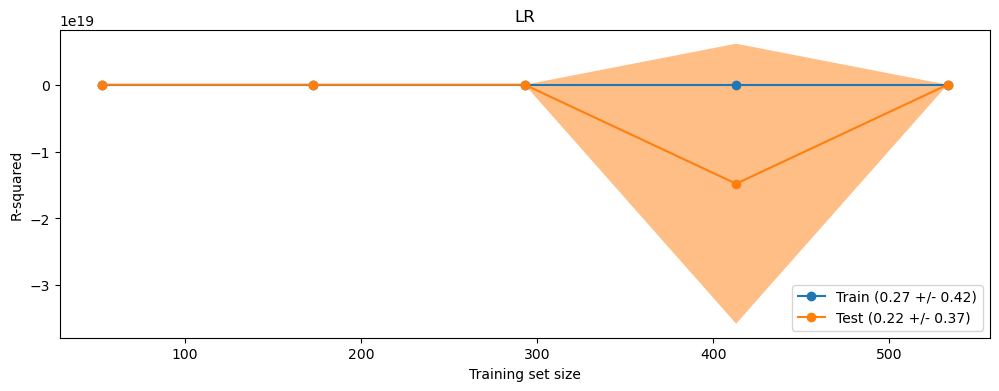

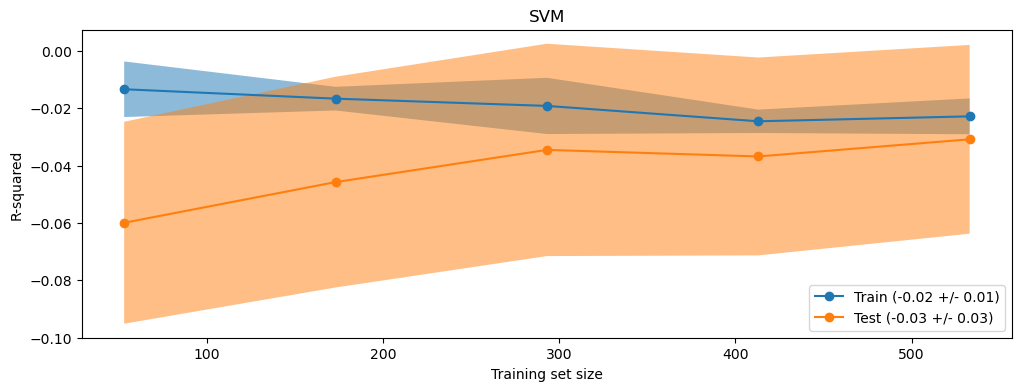

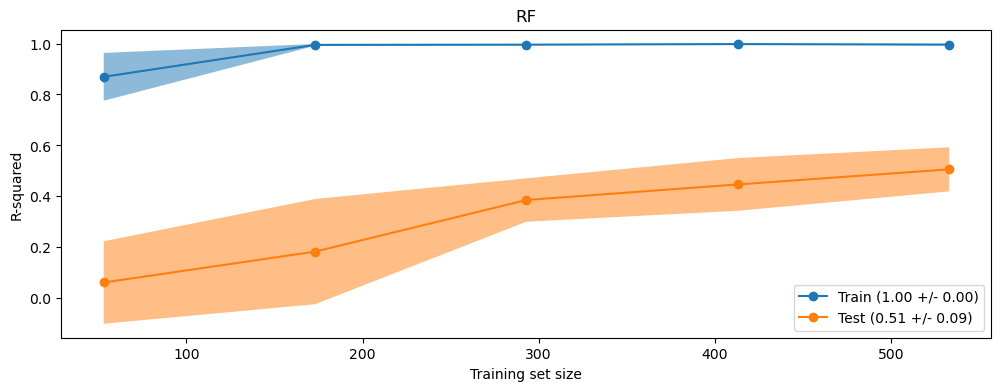

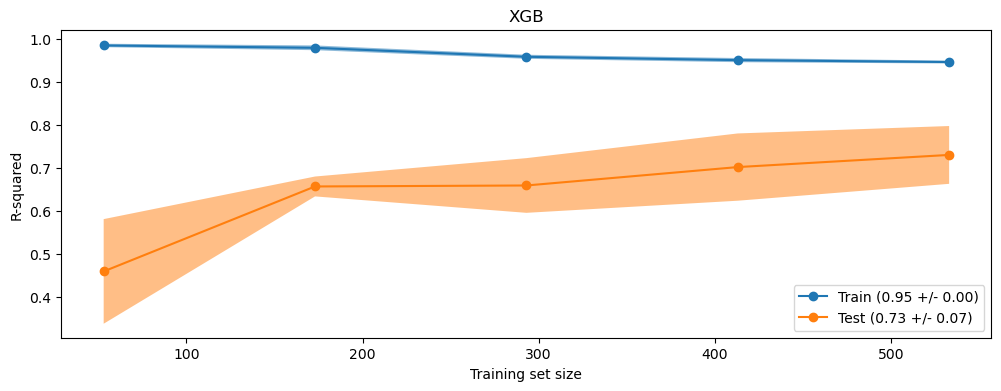

In [20]:
for name, alg in algo.items():
    plot_lc(name, alg)

*Selecting Random Forest*

#### Model training 

In [21]:
model = Pipeline(steps = [
    ("pre", preprocessor),
    ("rf" , RandomForestClassifier(n_estimators=10))
])

In [22]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impiter',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestClassifier(n_estimators=10))])

#### Model Evaluation

In [23]:
def evaluate_model(X, y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

In [24]:
print(f"R2 score on training data is {evaluate_model(X_data, y_data)}")

R2 score on training data is 0.9911250991913887


In [25]:
print(f"R2 score on test data is {evaluate_model(X_test, y_test)}")

R2 score on test data is 0.3284067138875836


#### Model Persistence 
Saving the model

In [26]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [27]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impiter',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestClassifier(n_estimators=10))])

In [28]:
y_pred = saved_model.predict(X_test)

r2_score(y_test, y_pred)

0.3284067138875836